<a href="https://colab.research.google.com/github/wbh0912/AML-Final-Project/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load packages
import os, time, urllib.request
import scipy.io as sio
import tensorflow as tf
import numpy as np
from sys import exit
from matplotlib import pyplot as plt
# Set seeds
np.random.seed(0)
tf.set_random_seed(0)
# Download datasets to virtual maching/local machine
urllib.request.urlretrieve(
    'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
    'train_32x32.mat')
urllib.request.urlretrieve(
    'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
    'test_32x32.mat')
# Include the line below only when using Jupyter notebook
# get_ipython().magic('matplotlib inline')

('test_32x32.mat', <http.client.HTTPMessage at 0x7f74d19d3b00>)

#Data preparation

In [0]:
# The dataset can be founnd here: http://ufldl.stanford.edu/housenumbers/
# We got our insights of creating dataset class here: https://github.com/wbh0912/VAE_SVHN/blob/master/dataset/dataset_svhn.py

# A class of one channel of all images
class SVHNDataset:
    def __init__(self, chan, db_path='/content', use_extra=False):
        print("Loading files")
        self.name = "svhn"
        self.train_file = os.path.join(db_path, "train_32x32.mat") # path for train file on VM
        self.test_file = os.path.join(db_path, "test_32x32.mat") # path for test file on VM
        print(self.train_file)
        
        # Load training images
        if os.path.isfile(self.train_file):
            mat = sio.loadmat(self.train_file) # entire train file
            self.train_label = mat['y']
            self.train_image = mat['X'] # 32 * 32 * 3 * 73257
            self.train_image = np.transpose(self.train_image, [3, 0, 1, 2]) \
                               [:, :, :, chan] # take the first channel
            self.train_image = np.clip(self.train_image / 255.0, a_min=0.0, a_max=1.0)
        else:
            print("SVHN dataset train files not found")
            exit(-1)
        self.train_batch_ptr = 0
        self.train_size = self.train_image.shape[0]

        if os.path.isfile(self.test_file):
            mat = sio.loadmat(self.test_file) # entire test file
            self.test_label = mat['y']
            self.test_image = mat['X'].astype(np.float32) 
            self.test_image = np.transpose(self.test_image, [3, 0, 1, 2]) \
                              [:, :, :, chan]
            self.test_image = np.clip(self.test_image / 255.0, a_min=0.0, a_max=1.0)
        else:
            print("SVHN dataset test files not found")
            exit(-1)
        self.test_batch_ptr = 0
        self.test_size = self.test_image.shape[0]
        print("SVHN_R loaded into memory")

    def next_batch(self, batch_size):
        prev_batch_ptr = self.train_batch_ptr
        self.train_batch_ptr += batch_size
        if self.train_batch_ptr > self.train_image.shape[0]:
            self.train_batch_ptr = batch_size
            prev_batch_ptr = 0
        return self.train_image[prev_batch_ptr:self.train_batch_ptr, :, :]

    def batch_by_index(self, batch_start, batch_end):
        return self.train_image[batch_start:batch_end, :, :]

    def next_test_batch(self, batch_size):
        prev_batch_ptr = self.test_batch_ptr
        self.test_batch_ptr += batch_size
        if self.test_batch_ptr > self.test_image.shape[0]:
            self.test_batch_ptr = batch_size
            prev_batch_ptr = 0
        return self.test_image[prev_batch_ptr:self.test_batch_ptr, :, :], self.test_label[prev_batch_ptr:self.test_batch_ptr]

    def reset(self):
        self.train_batch_ptr = 0
        self.test_batch_ptr = 0

#VAE model and training function

In [0]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    https://jmetzen.github.io/2015-11-27/vae.html
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.relu, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent space
        self.z_mean, self.z_log_sigma_sq = self._recognition_network(network_weights["weights_recog"], 
                                           network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                                dtype=tf.float32)
        self.z = tf.add(self.z_mean, 
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = self._generator_network(network_weights["weights_gener"],
                               network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1, n_hidden_gener_2, n_input, n_z):
        all_weights = dict()
        initializer = tf.contrib.layers.xavier_initializer()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(initializer(shape = [n_input, n_hidden_recog_1])),
            'h2': tf.Variable(initializer(shape = [n_hidden_recog_1, n_hidden_recog_2])),
            'out_mean': tf.Variable(initializer(shape = [n_hidden_recog_2, n_z])),
            'out_log_sigma': tf.Variable(initializer(shape = [n_hidden_recog_2, n_z]))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(initializer(shape = [n_z, n_hidden_gener_1])),
            'h2': tf.Variable(initializer(shape = [n_hidden_gener_1, n_hidden_gener_2])),
            'out_mean': tf.Variable(initializer(shape = [n_hidden_gener_2, n_input])),
            'out_log_sigma': tf.Variable(initializer(shape = [n_hidden_gener_2, n_input]))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2']))
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                         biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                          biases['out_mean']))
        
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                        + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean), 1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                      - tf.square(self.z_mean) - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, feed_dict={self.x: X})


In [0]:
# Train Function
def train(ds, network_architecture, 
          learning_rate=0.001, batch_size=100, training_epochs=10, display_step=1):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    n_samples = ds.train_size
    # Training cycle
    time_ = time.time()
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs= ds.next_batch(batch_size).reshape(batch_size,1024)
            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch: {:2d}, cost = {:2f}, time = {:2f} sec" \
                  .format(epoch+1, avg_cost, time.time()-time_))
    return vae

#Prepare Training Set

In [5]:
# Load SVHN Data into three dataset
dataset_R = SVHNDataset(0, '.')
dataset_G = SVHNDataset(1, '.')
dataset_B = SVHNDataset(2, '.')
train_set = [dataset_R, dataset_G, dataset_B]

# test samples
x_sample_R = dataset_R.next_test_batch(100)[0]
x_sample_G = dataset_G.next_test_batch(100)[0]
x_sample_B = dataset_B.next_test_batch(100)[0]
x_sample = np.transpose(np.stack((x_sample_R, x_sample_G, x_sample_B)), (1, 2, 3, 0))

Loading files
./train_32x32.mat
SVHN_R loaded into memory
Loading files
./train_32x32.mat
SVHN_R loaded into memory
Loading files
./train_32x32.mat
SVHN_R loaded into memory


In [0]:
# Train and reconstruct
def get_result(n_hr1=500, n_hr2=500, n_ls=20, n_epo=10,
                 ds=train_set, x_R=x_sample_R, x_G=x_sample_G, x_B=x_sample_B):
    net_archi = dict(n_hidden_recog_1=n_hr1, # 1st layer encoder neurons
                     n_hidden_recog_2=n_hr2, # 2nd layer encoder neurons
                     n_hidden_gener_1=n_hr2, # 1st layer decoder neurons
                     n_hidden_gener_2=n_hr1, # 2nd layer decoder neurons
                     n_input=1024,
                     n_z=n_ls) # dimensionality of latent space
    
    print("\n\n\nTraining: # neurons = ({}, {}), # latent space = {}, # epoch = {}\nChannel R" \
          .format(n_hr1, n_hr2, n_ls, n_epo))
    vae_R = train(ds[0], net_archi, training_epochs=n_epo, batch_size=100)
    print("\nChannel G")
    vae_G = train(ds[1], net_archi, training_epochs=n_epo, batch_size=100)
    print("\nChannel B")
    vae_B = train(ds[2], net_archi, training_epochs=n_epo, batch_size=100)
    
    # test output
    x_recons_R = vae_R.reconstruct(x_R.reshape(100,1024)).reshape(100, 32, 32)
    x_recons_G = vae_G.reconstruct(x_G.reshape(100,1024)).reshape(100, 32, 32)
    x_recons_B = vae_B.reconstruct(x_B.reshape(100,1024)).reshape(100, 32, 32)
    
    return np.transpose(np.stack((x_recons_R, x_recons_G, x_recons_B)), (1, 2, 3, 0))

#Comparison between different latent space dimension

In [7]:
x_ls10 = get_result(n_ls=10)
x_ls20 = get_result() # n_ls = 20
x_ls128 = get_result(n_ls=128)
x_ls512 = get_result(n_ls=512)




Training: # neurons = (500, 500), # latent space = 10, # epoch = 10
Channel R
Epoch:  1, cost = 657.353564, time = 4.359614 sec
Epoch:  2, cost = 646.741136, time = 8.441329 sec
Epoch:  3, cost = 645.581725, time = 12.429553 sec
Epoch:  4, cost = 645.329186, time = 16.393950 sec
Epoch:  5, cost = 645.147120, time = 20.310378 sec
Epoch:  6, cost = 644.664968, time = 24.234599 sec
Epoch:  7, cost = 644.081515, time = 28.178811 sec
Epoch:  8, cost = 643.697165, time = 32.109905 sec
Epoch:  9, cost = 643.408734, time = 36.042038 sec
Epoch: 10, cost = 643.281770, time = 39.973978 sec

Channel G


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:  1, cost = 657.681129, time = 3.995841 sec
Epoch:  2, cost = 646.345034, time = 7.950327 sec
Epoch:  3, cost = 645.504487, time = 11.902261 sec
Epoch:  4, cost = 645.205982, time = 15.865159 sec
Epoch:  5, cost = 644.731890, time = 19.800384 sec
Epoch:  6, cost = 644.378065, time = 23.739854 sec
Epoch:  7, cost = 643.925786, time = 27.670540 sec
Epoch:  8, cost = 643.699222, time = 31.605825 sec
Epoch:  9, cost = 643.580089, time = 35.571929 sec
Epoch: 10, cost = 643.268365, time = 39.554181 sec

Channel B
Epoch:  1, cost = 657.697142, time = 4.055598 sec
Epoch:  2, cost = 648.055798, time = 8.079823 sec
Epoch:  3, cost = 647.092355, time = 12.022275 sec
Epoch:  4, cost = 646.809171, time = 15.940163 sec
Epoch:  5, cost = 646.686130, time = 19.882133 sec
Epoch:  6, cost = 646.592782, time = 23.802486 sec
Epoch:  7, cost = 646.545584, time = 27.733929 sec
Epoch:  8, cost = 646.465844, time = 31.593662 sec
Epoch:  9, cost = 646.427850, time = 35.506817 sec
Epoch: 10, cost = 646.39

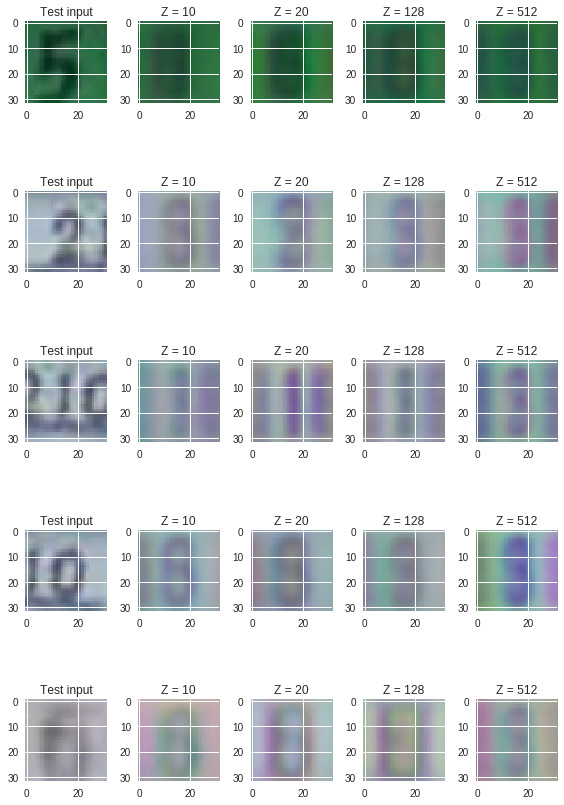

In [13]:
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 5, 5*i + 1)
    plt.imshow(x_sample[i])
    plt.title("Test input")
    plt.subplot(5, 5, 5*i + 2)
    plt.imshow(x_ls10[i])
    plt.title("Z = 10")
    plt.subplot(5, 5, 5*i + 3)
    plt.imshow(x_ls20[i])
    plt.title("Z = 20")
    plt.subplot(5, 5, 5*i + 4)
    plt.imshow(x_ls128[i])
    plt.title("Z = 128")
    plt.subplot(5, 5, 5*i + 5)
    plt.imshow(x_ls512[i])
    plt.title("Z = 512")
plt.tight_layout()
plt.savefig('change of latent dimension')

#Comparison between different layer width

In [14]:
x_lw100 = get_result(n_hr1=100, n_hr2=100)
x_lw200 = get_result(n_hr1=200, n_hr2=200)
x_lw500 = x_ls20 # n_hr1=500, n_hr2=500
x_lw1000 = get_result(n_hr1=1000, n_hr2=1000)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:  1, cost = 662.928002, time = 3.496332 sec
Epoch:  2, cost = 647.319861, time = 6.758004 sec
Epoch:  3, cost = 646.032450, time = 10.029232 sec
Epoch:  4, cost = 645.427823, time = 13.294436 sec
Epoch:  5, cost = 645.082099, time = 16.588384 sec
Epoch:  6, cost = 644.523004, time = 19.862287 sec
Epoch:  7, cost = 644.290539, time = 23.141551 sec
Epoch:  8, cost = 644.099436, time = 26.411836 sec
Epoch:  9, cost = 644.034449, time = 29.666899 sec
Epoch: 10, cost = 643.951146, time = 32.930672 sec

Channel G
Epoch:  1, cost = 665.698070, time = 3.520433 sec
Epoch:  2, cost = 648.238467, time = 6.771988 sec
Epoch:  3, cost = 646.262796, time = 10.021858 sec
Epoch:  4, cost = 645.694790, time = 13.297983 sec
Epoch:  5, cost = 645.473449, time = 16.621104 sec
Epoch:  6, cost = 645.013596, time = 20.064124 sec
Epoch:  7, cost = 644.662586, time = 23.394122 sec
Epoch:  8, cost = 644.221040, time = 26.652701 sec
Epoch:  9, cost = 644.049409, time = 29.923977 sec
Epoch: 10, cost = 643.81

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


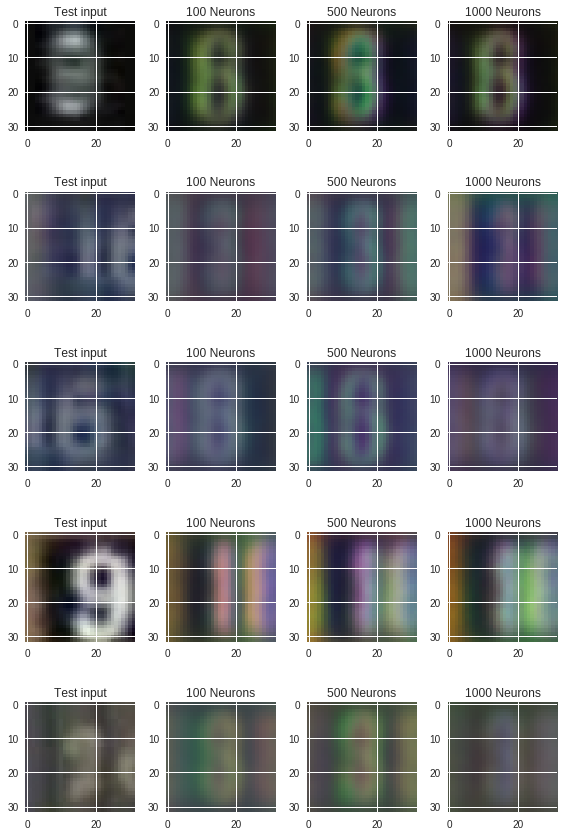

In [15]:
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 4, 4*i + 1)
    plt.imshow(x_sample[i+40])
    plt.title("Test input")
    plt.subplot(5, 4, 4*i + 2)
    plt.imshow(x_lw100[i+40])
    plt.title("100 Neurons")
    plt.subplot(5, 4, 4*i + 3)
    plt.imshow(x_lw200[i+40])
    plt.title("200 Neurons")
    plt.subplot(5, 4, 4*i + 3)
    plt.imshow(x_lw500[i+40])
    plt.title("500 Neurons")
    plt.subplot(5, 4, 4*i + 4)
    plt.imshow(x_lw1000[i+40])
    plt.title("1000 Neurons")
plt.tight_layout()
plt.savefig('change of neuron')

#Comparison between different network architecture

In [10]:
x_hr5h1k = get_result(n_hr1=500, n_hr2=1000)
x_hr5h5h = x_ls20 # n_hr1=500, n_hr2=500
x_hr5h2h = get_result(n_hr1=500, n_hr2=200)




Training: # neurons = (500, 1000), # latent space = 20, # epoch = 10
Channel R


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:  1, cost = 659.011444, time = 4.573886 sec
Epoch:  2, cost = 647.124284, time = 8.858234 sec
Epoch:  3, cost = 645.709082, time = 13.080574 sec
Epoch:  4, cost = 645.495561, time = 17.295604 sec
Epoch:  5, cost = 645.282961, time = 21.505742 sec
Epoch:  6, cost = 644.602449, time = 25.725791 sec
Epoch:  7, cost = 644.146855, time = 29.966179 sec
Epoch:  8, cost = 644.027596, time = 34.196277 sec
Epoch:  9, cost = 643.887205, time = 38.435303 sec
Epoch: 10, cost = 643.641248, time = 42.669333 sec

Channel G
Epoch:  1, cost = 659.295740, time = 4.413141 sec
Epoch:  2, cost = 646.390996, time = 8.670659 sec
Epoch:  3, cost = 645.624785, time = 13.027024 sec
Epoch:  4, cost = 645.340600, time = 17.272648 sec
Epoch:  5, cost = 644.700204, time = 21.505173 sec
Epoch:  6, cost = 644.333137, time = 25.710876 sec
Epoch:  7, cost = 643.943535, time = 29.957553 sec
Epoch:  8, cost = 643.771672, time = 34.203140 sec
Epoch:  9, cost = 643.711183, time = 38.460736 sec
Epoch: 10, cost = 643.61

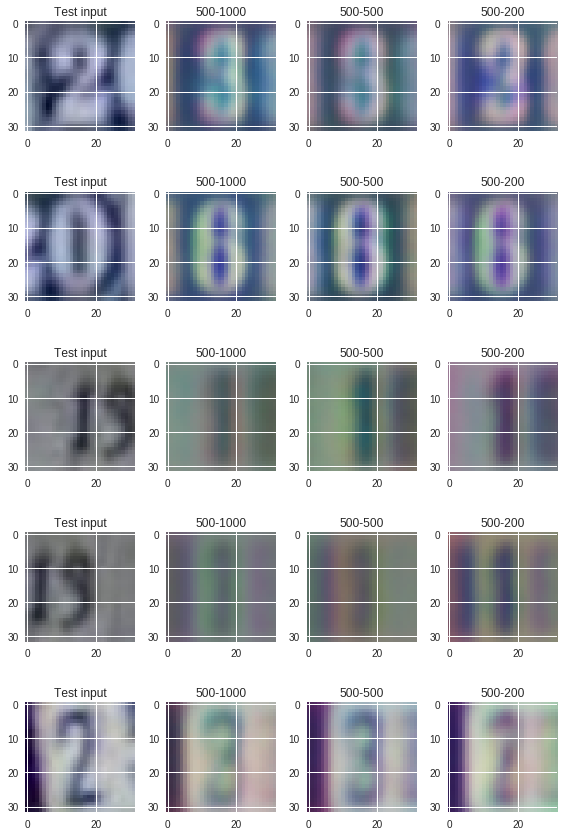

In [11]:
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 4, 4*i + 1)
    plt.imshow(x_sample[i+20])
    plt.title("Test input")
    plt.subplot(5, 4, 4*i + 2)
    plt.imshow(x_hr5h1k[i+20])
    plt.title("500-1000")
    plt.subplot(5, 4, 4*i + 3)
    plt.imshow(x_hr5h5h[i+20])
    plt.title("500-500")
    plt.subplot(5, 4, 4*i + 4)
    plt.imshow(x_hr5h2h[i+20])
    plt.title("500-200")
plt.tight_layout()
plt.savefig('change of arch')

#Comparison between different numbers of epochs

In [11]:
x_epo10 = x_ls20 # n_epo=10
x_epo20 = get_result(n_epo=20)
x_epo50 = get_result(n_epo=50)




Training: # neurons = (500, 500), # latent space = 20, # epoch = 20
Channel R


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:  1, cost = 658.855801, time = 3.878356 sec
Epoch:  2, cost = 646.534517, time = 7.589242 sec
Epoch:  3, cost = 645.664125, time = 11.280461 sec
Epoch:  4, cost = 645.456144, time = 14.978614 sec
Epoch:  5, cost = 644.939518, time = 18.668829 sec
Epoch:  6, cost = 644.481876, time = 22.349146 sec
Epoch:  7, cost = 644.121226, time = 26.108116 sec
Epoch:  8, cost = 643.994117, time = 29.982764 sec
Epoch:  9, cost = 643.891958, time = 33.769772 sec
Epoch: 10, cost = 643.707700, time = 37.621739 sec
Epoch: 11, cost = 643.456409, time = 41.479411 sec
Epoch: 12, cost = 643.261421, time = 45.293465 sec
Epoch: 13, cost = 643.146426, time = 49.054725 sec
Epoch: 14, cost = 642.989365, time = 52.810332 sec
Epoch: 15, cost = 642.885341, time = 56.562885 sec
Epoch: 16, cost = 642.811571, time = 60.330496 sec
Epoch: 17, cost = 642.746429, time = 64.107382 sec
Epoch: 18, cost = 642.762176, time = 67.879339 sec
Epoch: 19, cost = 642.632806, time = 71.651345 sec
Epoch: 20, cost = 642.664424, tim

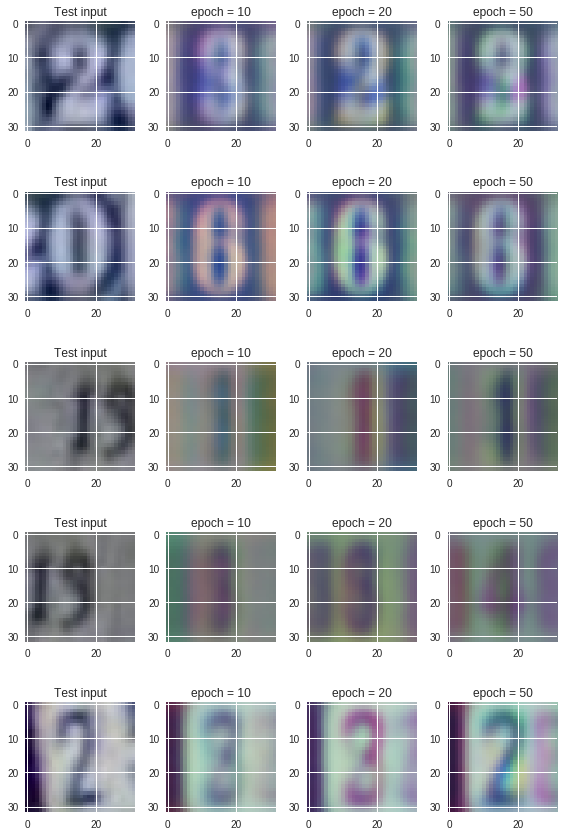

In [12]:
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 4, 4*i + 1)
    plt.imshow(x_sample[i+20])
    plt.title("Test input")
    plt.subplot(5, 4, 4*i + 2)
    plt.imshow(x_epo10[i+20])
    plt.title("epoch = 10")
    plt.subplot(5, 4, 4*i + 3)
    plt.imshow(x_epo20[i+20])
    plt.title("epoch = 20")
    plt.subplot(5, 4, 4*i + 4)
    plt.imshow(x_epo50[i+20])
    plt.title("epoch = 50")
plt.tight_layout()
plt.savefig('change of epoch')